# CSE 416 Intro to Machine Learning

### Assignment HW5 - Will a student complete their online course?

by Greg Pelletier, 14-Aug-2025

Assignment HW5 for University of Washington CSE 416 is described at the following link to the HW5 Kaggle competition:

https://www.kaggle.com/competitions/stat-cse-416-25-sp-assignment-5-hwsdh/overview

The solutions presented in this Jupyter Notebook resulted in the fourth highest accuracy score (public score 0.97196, private score 0.97751) in the leaderboard for the Kaggle competition.

This solution for HW5 uses five classification methods with the following functions from the PyMLR library to perform automated 5-fold cross-validated optimization of hyperparameters using optuna to maximize model accuracy:

 - **logistic_auto** - sklearn LogisticRegression using optuna for automatic cross-validated optimization of the hyperparameter
 - **xgb_auto** - XGBoost XGBClassifier using optuna for automatic cross-validated optimization of the hyperparameters
 - **svr_auto** - sklearn C-Support Vector Classification (SVC) using optuna for automatic cross-validated optimization of the hyperparameters
 - **knn_auto** - sklearn KNeighborsClassifier using optuna for automatic cross-validated optimization of the hyperparameters
 - **forest_auto** - sklearn RandomForestClassifier using optuna for automatic cross-validated optimization of the hyperparameters

For each method the user provides an input range of hyperparameter values to analyze, and the functions deterimine the optimum values of each hyperparameter that maximizes cross-validated model accuracy. Each method also performs automated feature selection using SelectKBest, mutual_info regression, and f_regression in the optuna optimization pipeline

Each function preprocesses X by default to standardize continuous features and one-hot encode categorical features. The functions also provide outputs of the scaler and encoder used for the training dataset so that the same scaler and encoder can be used to make predictions with the test data set used for submission to the competition.

Each method is presented below showing the following three steps for each method:

1) Train the model using X_train and y_train from the data in edx_train.csv and produce output of the model skill metrics and graphics including the best accuracy cross_val_score from the k-fold CV, accuracy of the final fitted model, precision, recall, confusion matrix, and the ROC curve with AUC
2) Test predictions of the response variable using X_test from the data in edx_test.csv
3) Interpretability analysis to show **a)** the optuna results of the optimum set of hyperparameters, the optimization history (accuracy score for each trial), relative importance of each hyperparameter on model predictions, and the contour plots of the model accuracy vs the two most important hyperparameters, and **b)** the model agnostics using either SHAP beeswarm/bar plots or Permutation Importance plots to show the relative imoprtance of the most important model features.

Run the following code in your Python environment to install PyMLR if you have not already installed it:

In [1]:
# !pip install git+https://github.com/gjpelletier/PyMLR.git --upgrade

### Load the data

The edx_train.csv and edx_test.csv files are available for download from Kaggle at the following link:

https://www.kaggle.com/competitions/stat-cse-416-25-sp-assignment-5-hwsdh/data

In this section we read the csv files into pandas dataframes from the working directory of this notebook.

In [1]:
import pandas as pd

# read train data into dataframe train
train_path = "edx_train.csv"
df_train = pd.read_csv(train_path)
print("Full train dataset shape is {}".format(df_train.shape))

# read test data into dataframe test
test_path = "edx_test.csv"
df_test = pd.read_csv(test_path)
print("Full test dataset shape is {}".format(df_test.shape))

Full train dataset shape is (8758, 17)
Full test dataset shape is (2920, 16)


### Check the dataset dtypes, number unique values, and number of missing values

In this section we check each column of the df_train and df_test dataframes to look example the dtype of each column and the nuber of unique values and the number of missing values in each column

In [2]:
from PyMLR import show_dtypes
dtypes_train = show_dtypes(df_train)

                     dtype nunique isna_sum
course_id           object       5        0
userid_DI           object    8758        0
registered           int64       1        0
viewed               int64       2        0
explored             int64       2        0
certified            int64       2        0
final_cc_cname_DI   object      34        0
LoE_DI              object       5      966
YoB                float64      70      914
gender              object       2      775
start_time_DI       object     409        0
last_event_DI       object     360     1508
nevents            float64    2822     1639
ndays_act          float64     114     1639
nplay_video        float64     990     6747
nchapters          float64      34     2563
nforum_posts         int64       8        0


In [3]:
dtypes_test = show_dtypes(df_test)

                     dtype nunique isna_sum
course_id           object       5        0
userid_DI           object    2920        0
registered           int64       1        0
viewed               int64       2        0
explored             int64       2        0
final_cc_cname_DI   object      34        0
LoE_DI              object       5      351
YoB                float64      63      310
gender              object       2      260
start_time_DI       object     405        0
last_event_DI       object     302      559
nevents            float64    1258      601
ndays_act          float64      97      601
nplay_video        float64     419     2261
nchapters          float64      34      908
nforum_posts         int64       6        0


### Fill missing values in the train data

In this section we will fill in missing numeric features using sklearn IterativeImputer, and will fill missing categorical string features with the category 'Unknown'. The end result is a dataframe with no missing values.

In [4]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

df_train2 = df_train.copy()

# impute missing values in numeric columns
numerical_cols = df_train2.select_dtypes(include='number').columns.tolist()
numerical_cols.remove('certified')
imputer = IterativeImputer(max_iter=20, random_state=0)
imputed_data = imputer.fit_transform(df_train[numerical_cols])
df_imputed = pd.DataFrame(imputed_data, columns=numerical_cols)
df_train2[numerical_cols] = df_imputed

# fill missing values in non-numeric columns with "Unknown"
non_numeric_cats = df_train2.select_dtypes(exclude=['number']).columns.tolist()    
for col in non_numeric_cats:
    df_train2[col] = df_train2[col].fillna('Unknown')

dtypes_train2 = show_dtypes(df_train2)    

                     dtype nunique isna_sum
course_id           object       5        0
userid_DI           object    8758        0
registered         float64       1        0
viewed             float64       2        0
explored           float64       2        0
certified            int64       2        0
final_cc_cname_DI   object      34        0
LoE_DI              object       6        0
YoB                float64     719        0
gender              object       3        0
start_time_DI       object     409        0
last_event_DI       object     361        0
nevents            float64    2883        0
ndays_act          float64     175        0
nplay_video        float64    5407        0
nchapters          float64     412        0
nforum_posts       float64       8        0


### Fill missing values in the test data

The same method is used to fill missing values in the test data.

In [5]:
df_test2 = df_test.copy()

imputed_data_test = imputer.fit_transform(df_test[numerical_cols])
df_imputed_test = pd.DataFrame(imputed_data_test, columns=numerical_cols)
df_test2[numerical_cols] = df_imputed_test

# fill missing values in non-numeric columns with "Unknown"
for col in non_numeric_cats:
    df_test2[col] = df_test2[col].fillna('Unknown')

### Define X_train, y_train, and X_test

X_train and y_train will be used for model training. X_test will be used for model predictions to submit to the Kaggle competition. 

In [6]:
# list of candidate features for the model
candidate_features = df_train2.columns.to_list()
candidate_features.remove('certified')
candidate_features.remove('userid_DI')
candidate_features.remove('start_time_DI')
candidate_features.remove('last_event_DI')

# X_train, y_train, and X_test
X_train = df_train2[candidate_features].copy()
y_train = df_train2['certified'].copy()
X_test = df_test2[candidate_features].copy()

# PyMLR logistic_auto 

### 1. Train the model using X_train and y_train

The logistic_auto function uses optuna to perform 5-fold cross-validated optimization of the best set of hyerparamters to maximize the accuracy of the model. The logistic_auto function preprocesses X by default to standardize continuous features and one-hot encode categorical features.

Running optuna to find best parameters, could take a few minutes, please wait...
Fitting LogisticRegression model with best parameters, please wait ...

LogisticRegression goodness of fit to training data in model_outputs['stats']:

| Statistic          |   LogisticRegression |
|:-------------------|---------------------:|
| mcfadden_pseudo_r2 |            0.821661  |
| accuracy           |            0.959009  |
| f1_score           |            0.954063  |
| precision          |            0.949567  |
| recall             |            0.958601  |
| log_loss           |            0.122496  |
| brier_score        |            0.0313265 |
| n_classes          |            2         |
| n_samples          |         8758         |


Best-fit score of CV test data: 0.957639

Done
Time elapsed: 369.50 sec



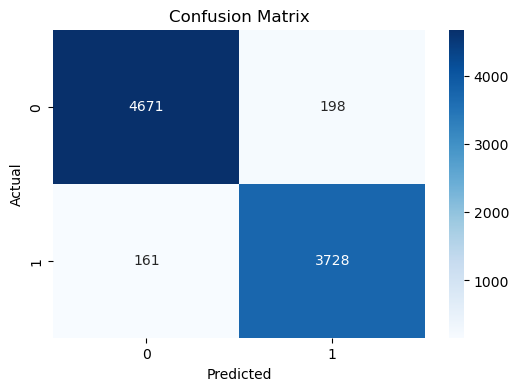

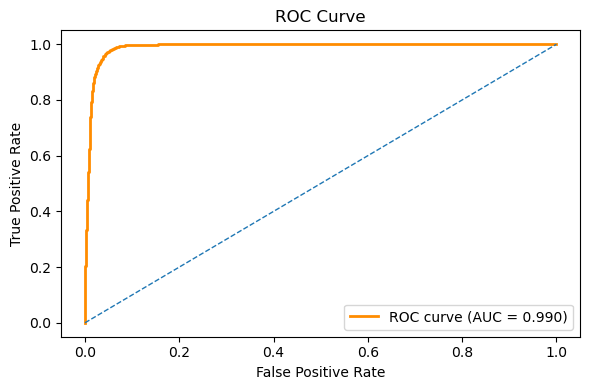

In [8]:
kwargs = {
    # user-specified params
    'random_state': 42,                 # random seed for reproducibility
    'n_trials': 50,                     # number of optuna trials
    # [min,max] model params that are optimized by optuna
    'C': [1e-4, 10],                    # Inverse of regularization strength
    # categorical model params optimized by optuna
    'solver': ['liblinear', 'lbfgs', 'saga'],   # optimization algorithm
    'penalty': ['l1', 'l2'],            # norm of the penalty
    # model extra_params that are optional user-specified
    'max_iter': 500,                    # max iterations for solver
    'n_jobs': -1                        # -1 to use all CPU cores
}    

from PyMLR import logistic_auto
train_model_logistic, train_output_logistic = logistic_auto(X_train, y_train, **kwargs)

### 2. Test predictions using X_test

In this section we will predict the values of the 'certified' response variable for the X_test dataset. These predictions are then put into a csv for submission in the format required for the Kaggle competion at the following link:

https://www.kaggle.com/competitions/stat-cse-416-25-sp-assignment-5-hwsdh/overview

To standardize and encode the testing data we will use the same preprocess_result scaler and encoder that were used to standardize and encode the training data to avoid data leakage between the training and testing data. We will also use the same optimized selected features that were determined during the training.

In [9]:
from PyMLR import preprocess_test

preprocess_result= train_output_logistic['preprocess_result']
selected_features= train_output_logistic['selected_features']
X_test_proc = preprocess_test(X_test, preprocess_result)
model = train_model_logistic
predictions = model.predict(X_test_proc[selected_features])

# Save your predictions as a CSV
to_save = df_test[['userid_DI']].copy()
to_save.loc[:, 'certified'] = predictions
to_save.to_csv('submission_logistic_auto_v6.csv', index=False)

### 3. Optuna results and model agnostics

In this section we will show a) the optuna results for the optimum values of the hyperparameters, the optimization history, the relative importance of each hyperparameter for model predictions, and contour plots of the model accuracy vs the two most important hyperparameters, and b) the model agnostic SHAP beeswarm and bar plots showing the relative importance of the most important features.

Best parameters:

C: 5.49274859006329
solver: lbfgs
num_features: 61

Best score: 0.9576390138446655



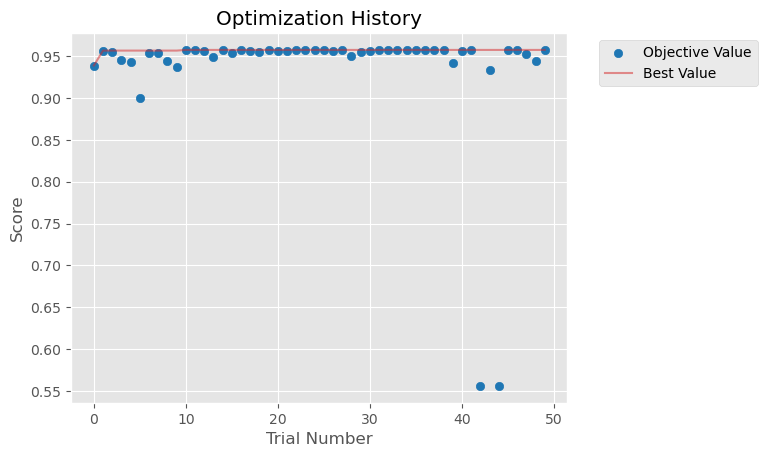

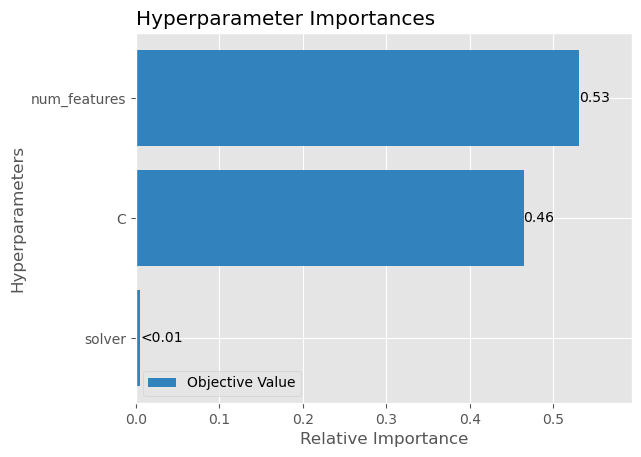

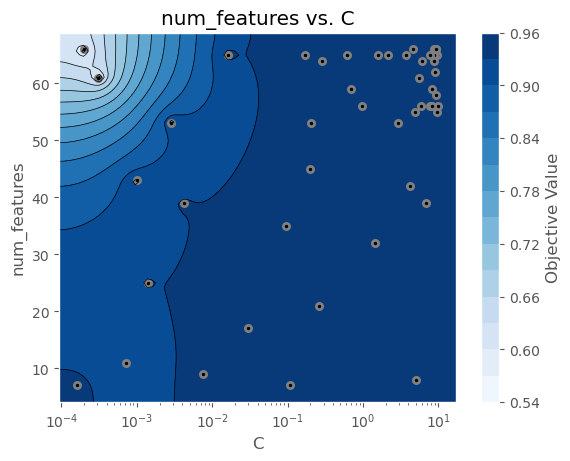

In [10]:
# a. optuna results 
from PyMLR import show_optuna
show_optuna(train_output_logistic['optuna_study'])

Performing model agnostic analysis, please wait...
SHAP Beeswarm and Bar importance...


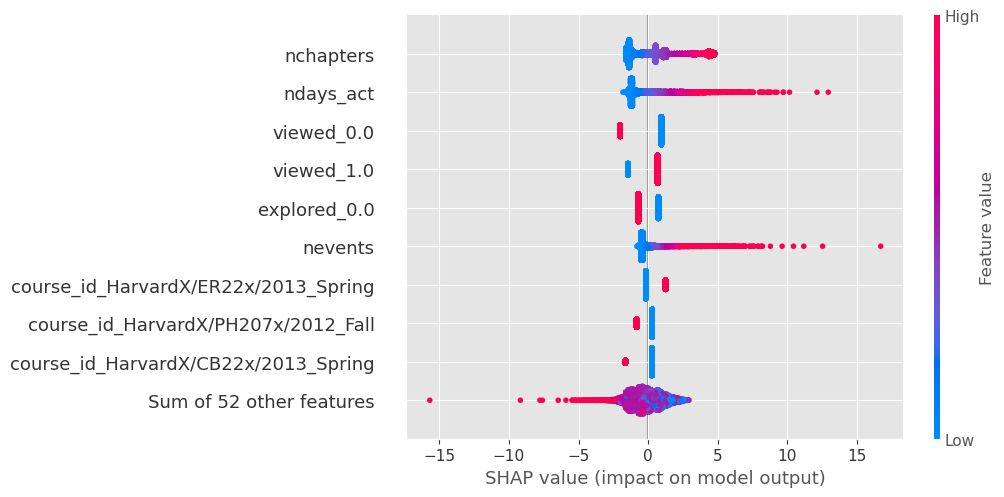

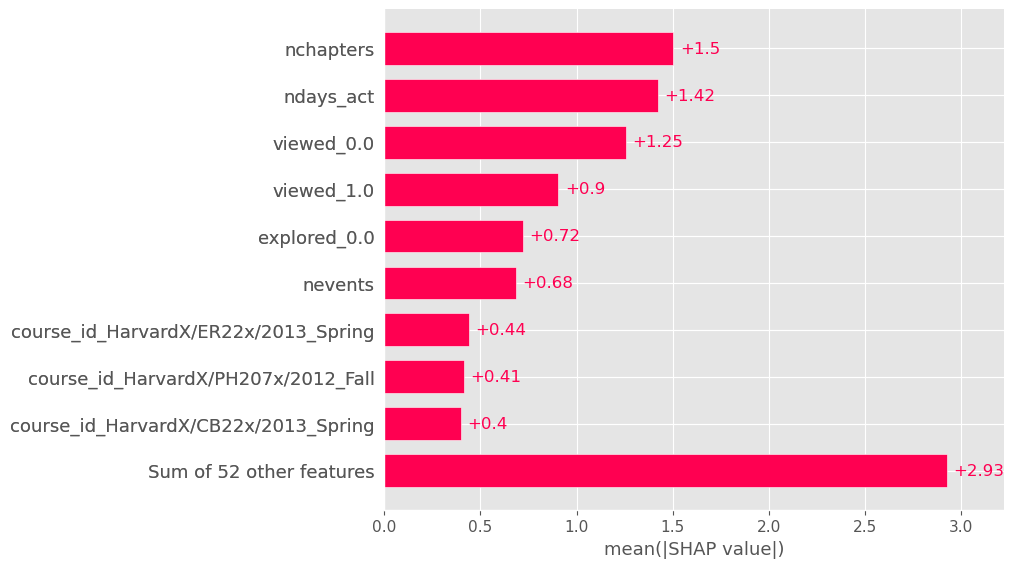

Interpretability plots saved to: model_agnostic
Done
Time elapsed: 1.74 sec



In [11]:
# b. Model agnostics
from PyMLR import model_agnostic
agnostic_output_logistic = model_agnostic(train_model_logistic, X_train, y_train, 
    preprocess_result= train_output_logistic['preprocess_result'],
    selected_features= train_output_logistic['selected_features'],
    output_dir= 'model_agnostic', show_shap=True)

# PyMLR xgb_auto

### 1. Train the model using X_train and y_train

Running optuna to find best parameters, could take a few minutes, please wait...
Fitting XGBClassifier model with best parameters, please wait ...

XGBClassifier goodness of fit to training data in model_outputs['stats']:

| Statistic          |   XGBClassifier |
|:-------------------|----------------:|
| mcfadden_pseudo_r2 |       0.928837  |
| accuracy           |       0.984586  |
| f1_score           |       0.982835  |
| precision          |       0.972082  |
| recall             |       0.993829  |
| log_loss           |       0.0488799 |
| n_classes          |       2         |
| n_samples          |    8758         |


Best-fit score of CV test data: 0.973338

Done
Time elapsed: 1574.57 sec



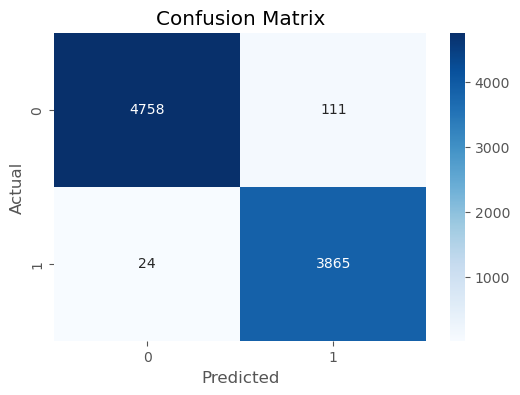

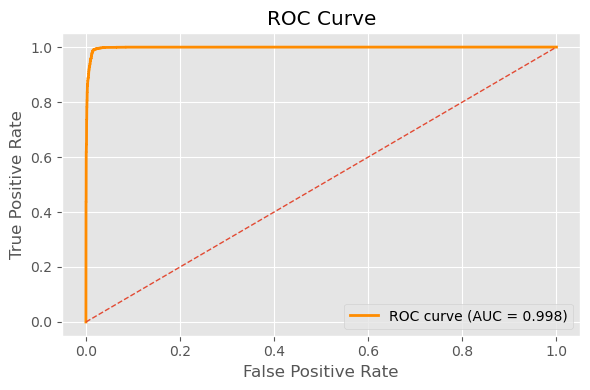

In [12]:
# optional keyword arguments
kwargs = {
    # [min, max] range of params that are optimized by optuna
    'classify': True,               # Use XGBClassifier
    'random_state': 42,             # random seed for reproducibility
    'n_trials': 50,                 # number of optuna trials
    'learning_rate': [1e-4, 1.0],   # step size shrinkage (also called eta)
    'max_depth': [3, 12],           # maximum depth of a tree
    'min_child_weight': [1, 10],    # minimum sum of instance weight (hessian) needed in a child
    'subsample': [0.5, 1],          # fraction of samples used for training each tree
    'colsample_bytree': [0.5, 1],   # fraction of features used for each tree
    'gamma': [1e-8, 10.0],          # minimum loss reduction to make a split
    'reg_lambda': [1e-8, 10.0],     # L2 regularization term on weights
    'alpha': [1e-8, 10.0],          # L1 regularization term on weights
    'n_estimators': [100, 1000]     # number of boosting rounds (trees)
}    

from PyMLR import xgb_auto
train_model_xgb, train_output_xgb = xgb_auto(X_train, y_train, **kwargs)

### 2. Test predictions using X_test

In [13]:
from PyMLR import preprocess_test

preprocess_result= train_output_xgb['preprocess_result']
selected_features= train_output_xgb['selected_features']
X_test_proc = preprocess_test(X_test, preprocess_result)
model = train_model_xgb
predictions = model.predict(X_test_proc[selected_features])

# Save your predictions as a CSV
to_save = df_test[['userid_DI']].copy()
to_save.loc[:, 'certified'] = predictions
to_save.to_csv('submission_xgb_auto_v6.csv', index=False)

### 3. Optuna results and model agnostics

Best parameters:

learning_rate: 0.03188022998440852
max_depth: 10
min_child_weight: 7
subsample: 0.7914734264408851
colsample_bytree: 0.5180133883430705
gamma: 0.0007301427655269084
reg_lambda: 0.00023018128925593259
alpha: 7.890526548590521e-05
n_estimators: 743
num_features: 38
selector_type: f_regression

Best score: 0.9733377730664017



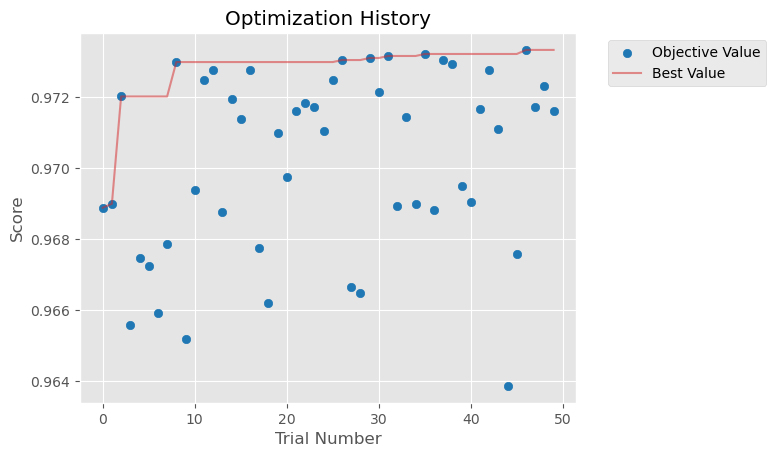

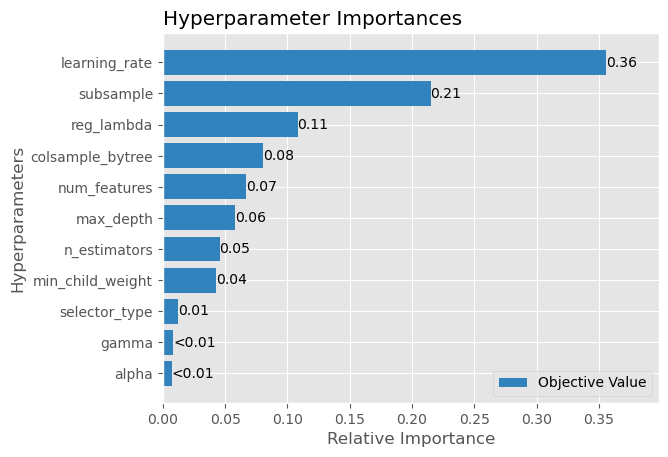

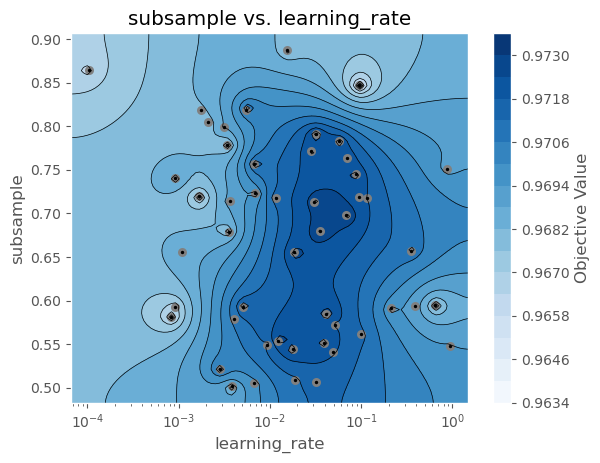

In [14]:
# a. Optuna results
from PyMLR import show_optuna
show_optuna(train_output_xgb['optuna_study'])

Performing model agnostic analysis, please wait...
SHAP Beeswarm and Bar importance...


100%|===================| 8747/8758 [02:23<00:00]        

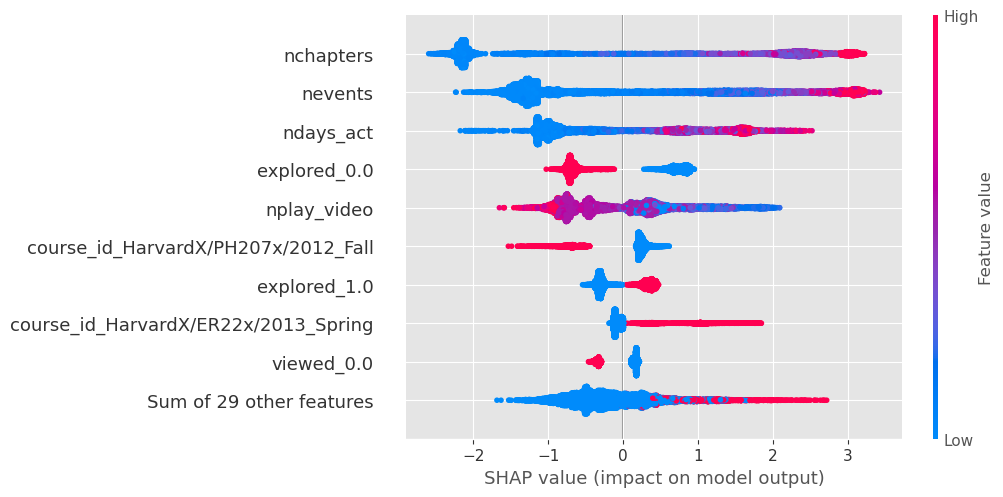

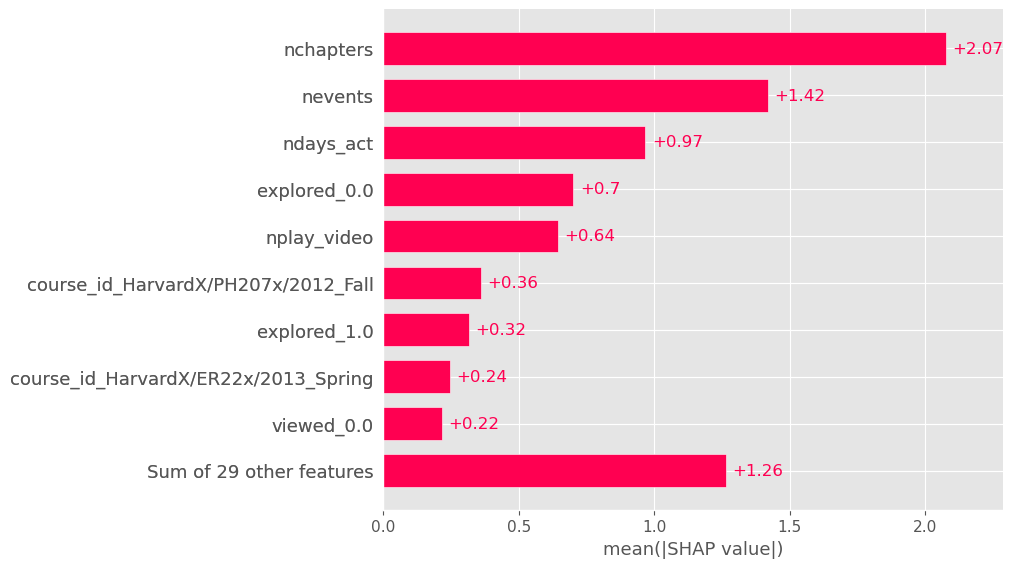

Interpretability plots saved to: model_agnostic
Done
Time elapsed: 146.40 sec



In [15]:
# b. Model agnostics
from PyMLR import model_agnostic
agnostic_output_xgb = model_agnostic(train_model_xgb, X_train, y_train, 
    preprocess_result= train_output_xgb['preprocess_result'],
    selected_features= train_output_xgb['selected_features'],
    output_dir= 'model_agnostic', show_shap=True)

# PyMLR svr_auto

### 1. Train the model using X_train and y_train

Running optuna to find best parameters, could take a few minutes, please wait...
Fitting SVC model with best parameters, please wait ...

SVC goodness of fit to training data in model_outputs['stats']:

| Statistic          |          SVC |
|:-------------------|-------------:|
| mcfadden_pseudo_r2 |    0.866741  |
| accuracy           |    0.97625   |
| f1_score           |    0.973757  |
| precision          |    0.955908  |
| recall             |    0.992286  |
| log_loss           |    0.0915322 |
| n_classes          |    2         |
| n_samples          | 8758         |


Best-fit score of CV test data: 0.972025

Done
Time elapsed: 413.31 sec



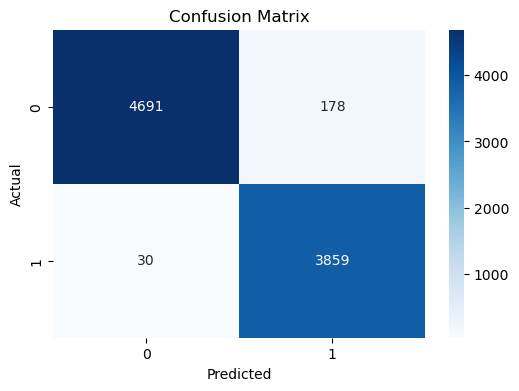

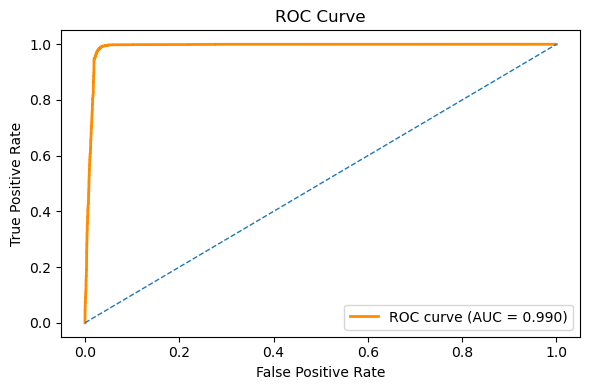

In [7]:
# optional keyword arguments
kwargs = {
    # [min, max] range of params that are optimized by optuna
    'classify': True,           # Use SVC classifier
    'random_state': 42,         # random seed for reproducibility
    'n_trials': 50,             # number of optuna trials
    'C': [0.1, 1000],           # C Regularization parameter
    'gamma': 'scale'            # 'scale', 'auto', or [min, max]
}

from PyMLR import svr_auto
train_model_svr, train_output_svr = svr_auto(X_train, y_train, **kwargs)

### 2. Test predictions using X_test

In [8]:
from PyMLR import preprocess_test

preprocess_result= train_output_svr['preprocess_result']
selected_features= train_output_svr['selected_features']
X_test_proc = preprocess_test(X_test, preprocess_result)
model = train_model_svr
predictions = model.predict(X_test_proc[selected_features])

# Save your predictions as a CSV
to_save = df_test[['userid_DI']].copy()
to_save.loc[:, 'certified'] = predictions
to_save.to_csv('submission_svr_auto_v6.csv', index=False)

### 3. Optuna results and model agnostics

Best parameters:

C: 913.836150976293
num_features: 12
selector_type: f_regression

Best score: 0.9720248898867965



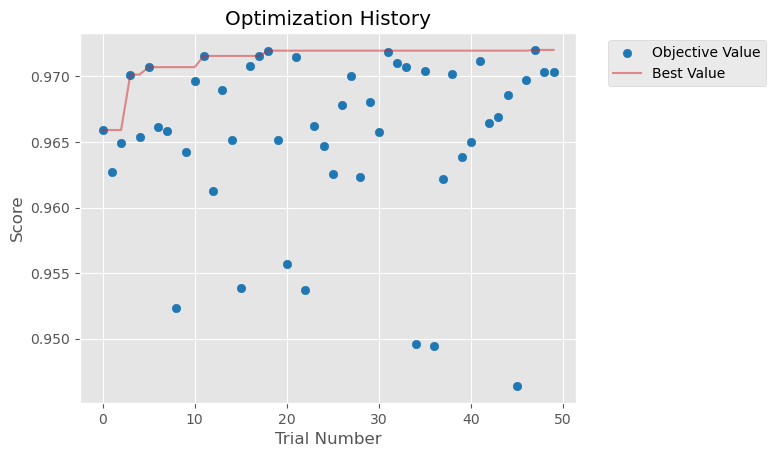

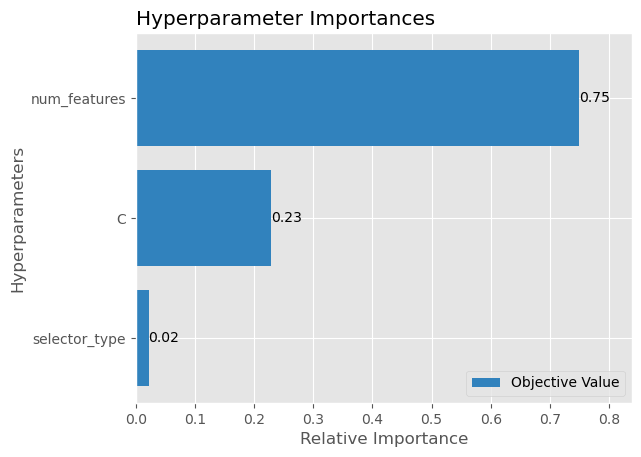

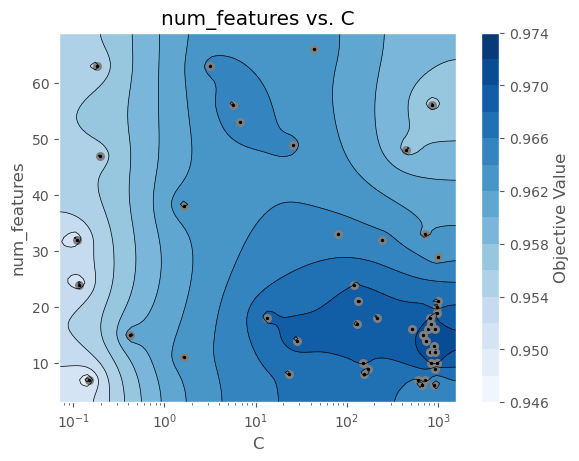

In [9]:
# a. Optuna results
from PyMLR import show_optuna
show_optuna(train_output_svr['optuna_study'])

Performing model agnostic analysis, please wait...
Permutation Importance...


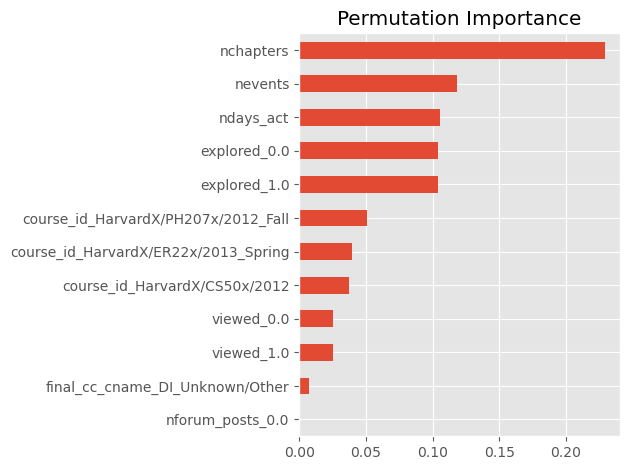

Interpretability plots saved to: model_agnostic
Done
Time elapsed: 17.04 sec



In [10]:
# b. Model agnostics (Note SHAP does not support SVC, look at Permutation Imporatnce instead)
from PyMLR import model_agnostic
agnostic_output_svr = model_agnostic(train_model_svr, X_train, y_train, 
    preprocess_result= train_output_svr['preprocess_result'],
    selected_features= train_output_svr['selected_features'],
    output_dir= 'model_agnostic', show_perm=True)

# PyMLR knn_auto

### 1. Train the model using X_train and y_train

Running optuna to find best parameters, could take a few minutes, please wait...
Fitting KNeighborsClassifier model with best parameters, please wait ...

KNeighborsClassifier goodness of fit to training data in model_outputs['stats']:

| Statistic          |   KNeighborsClassifier |
|:-------------------|-----------------------:|
| mcfadden_pseudo_r2 |            1           |
| accuracy           |            1           |
| f1_score           |            1           |
| precision          |            1           |
| recall             |            1           |
| log_loss           |            2.22045e-16 |
| n_classes          |            2           |
| n_samples          |         8758           |


Best-fit score of CV test data: 0.969113

Done
Time elapsed: 273.77 sec



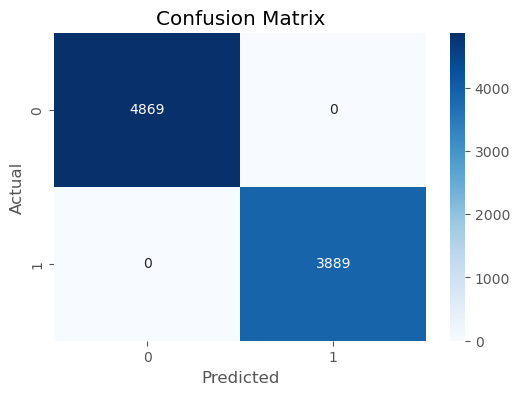

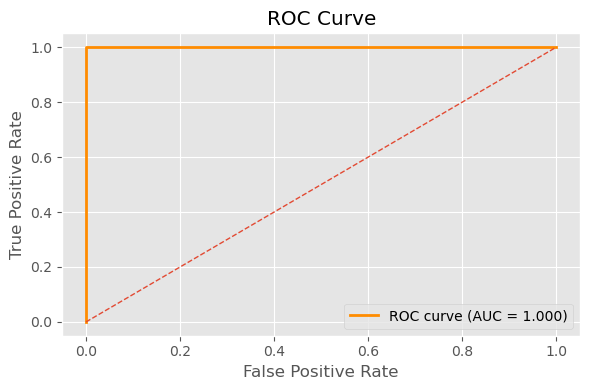

In [11]:
kwargs = {
    # user-specified params
    'classify': True,                   # True to use KNeighborsClassifier
    'random_state': 42,                 # random seed for reproducibility
    'n_trials': 50,                     # number of optuna trials
    # [min,max] model params that are optimized by optuna
    'n_neighbors': [1, 50],             # number of neighbors
    'p': [1, 5],                        # power for Minkowski
    'leaf_size': [5, 100],              # Leaf size for BallTree or KDTree
    # categorical model params optimized by optuna
    'weights': ["uniform", "distance"],  # weight function
    'metric': ["euclidean", "manhattan", "minkowski"],  # for distance comp
    'algorithm': ["ball_tree", "kd_tree", "brute"],    # algorithm    
    # model extra_params that are optional user-specified
    'n_jobs': -1,                       # number of jobs to run in parallel
                                        # -1 to use all CPU cores
    'metric_params': None               # for user-specified metrics
}    

from PyMLR import knn_auto
train_model_knn, train_output_knn = knn_auto(X_train, y_train, **kwargs)

### 2. Test predictions using X_test

In [12]:
from PyMLR import preprocess_test

preprocess_result= train_output_knn['preprocess_result']
selected_features= train_output_knn['selected_features']
X_test_proc = preprocess_test(X_test, preprocess_result)
model = train_model_knn
predictions = model.predict(X_test_proc[selected_features])

# Save your predictions as a CSV
to_save = df_test[['userid_DI']].copy()
to_save.loc[:, 'certified'] = predictions
to_save.to_csv('submission_knn_auto_v6.csv', index=False)

### 3. Optuna results and model agnostics

Best parameters:

n_neighbors: 18
leaf_size: 21
weights: distance
metric: manhattan
algorithm: kd_tree
num_features: 14
selector_type: f_regression

Best score: 0.9691131812480279



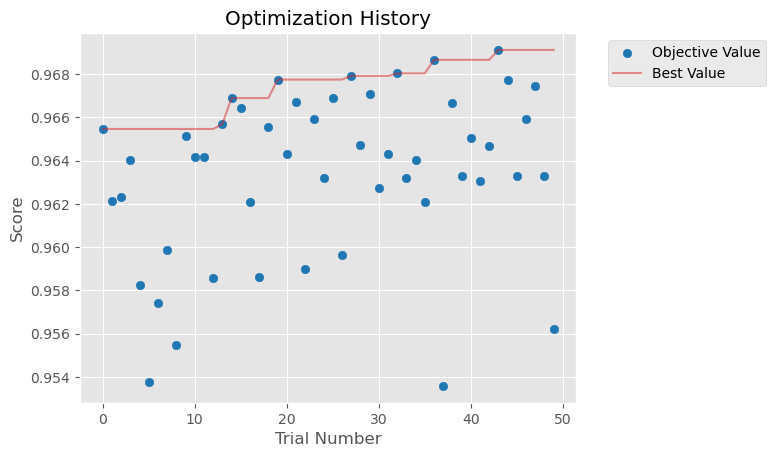

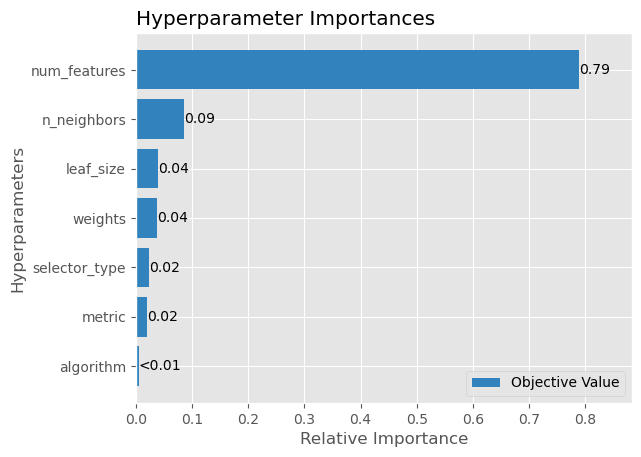

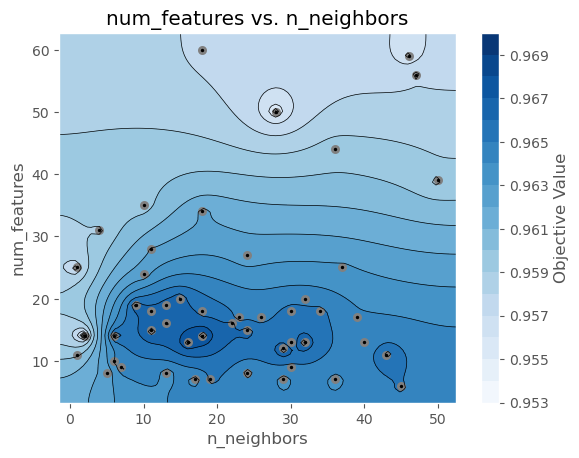

In [13]:
# a. Optuna results
from PyMLR import show_optuna
show_optuna(train_output_knn['optuna_study'])

Performing model agnostic analysis, please wait...
Permutation Importance...


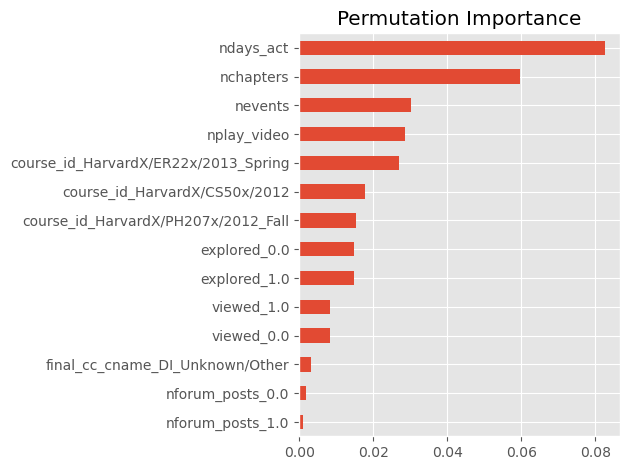

Interpretability plots saved to: model_agnostic
Done
Time elapsed: 20.89 sec



In [14]:
# b. Model agnostics
from PyMLR import model_agnostic
agnostic_output_knn = model_agnostic(train_model_knn, X_train, y_train, 
    preprocess_result= train_output_knn['preprocess_result'],
    selected_features= train_output_knn['selected_features'],
    output_dir= 'model_agnostic', show_perm=True)

# PyMLR forest_auto

### 1. Train the model using X_train and y_train

Running optuna to find best parameters, could take a few minutes, please wait...
Fitting RandomForestClassifier model with best parameters, please wait ...

RandomForestClassifier goodness of fit to training data in model_outputs['stats']:

| Statistic          |   RandomForestClassifier |
|:-------------------|-------------------------:|
| mcfadden_pseudo_r2 |                0.876207  |
| accuracy           |                0.974081  |
| f1_score           |                0.971248  |
| precision          |                0.957064  |
| recall             |                0.985858  |
| log_loss           |                0.0850301 |
| n_classes          |                2         |
| n_samples          |             8758         |


Best-fit score of CV test data: 0.970655

Done
Time elapsed: 824.06 sec



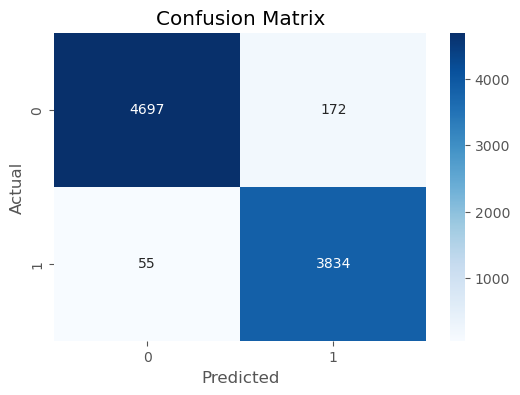

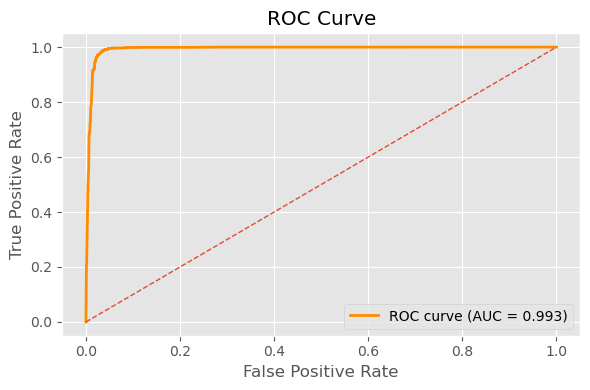

In [15]:
# optional keyword arguments
kwargs = {
    'classify': True,                   # True to use RandomForestClassifier
    'random_state': 42,                 # random seed for reproducibility
    'n_trials': 50,                     # number of optuna trials
    # [min, max] range of params that are optimized by optuna
    'n_estimators': [50, 500],          # number of trees in the forest
    'max_depth': [3, 30],               # max depth of a tree
    'min_samples_split': [2, 50],       # min samples to split internal node
    'min_samples_leaf': [1, 50],        # min samples to be at a leaf node
    'max_features': [0.1, 1.0],         # number of features to consider 
                                        # when looking for the best split
    'max_leaf_nodes': [10, 1000],       # max number of leaf nodes
    'min_impurity_decrease': [0.0, 0.1],   # node will be split if this 
                                           # induces a decrease of the impurity 
                                           # greater than or equal to this value
    'ccp_alpha': [0.0001, 0.1],         # parameter for 
                                        # Minimum Cost-Complexity Pruning
    # categorical variable optimzed by optuna
    'bootstrap': [True, False]          # whether bootstrap samples are used
    }
    
from PyMLR import forest_auto
train_model_forest, train_output_forest = forest_auto(X_train, y_train, **kwargs)

### 2. Test predictions using X_test

In [16]:
from PyMLR import preprocess_test

preprocess_result= train_output_forest['preprocess_result']
selected_features= train_output_forest['selected_features']
X_test_proc = preprocess_test(X_test, preprocess_result)
model = train_model_forest
predictions = model.predict(X_test_proc[selected_features])

# Save your predictions as a CSV
to_save = df_test[['userid_DI']].copy()
to_save.loc[:, 'certified'] = predictions
to_save.to_csv('submission_forest_auto_v6.csv', index=False)

### 3. Optuna results and model agnostics

Best parameters:

n_estimators: 394
max_depth: 21
min_samples_split: 36
min_samples_leaf: 1
max_features: 0.5491883085018231
max_leaf_nodes: 54
min_impurity_decrease: 0.00026134323283097676
ccp_alpha: 0.0002972132082961415
bootstrap: False
num_features: 56
selector_type: mutual_info

Best score: 0.9706546683043479



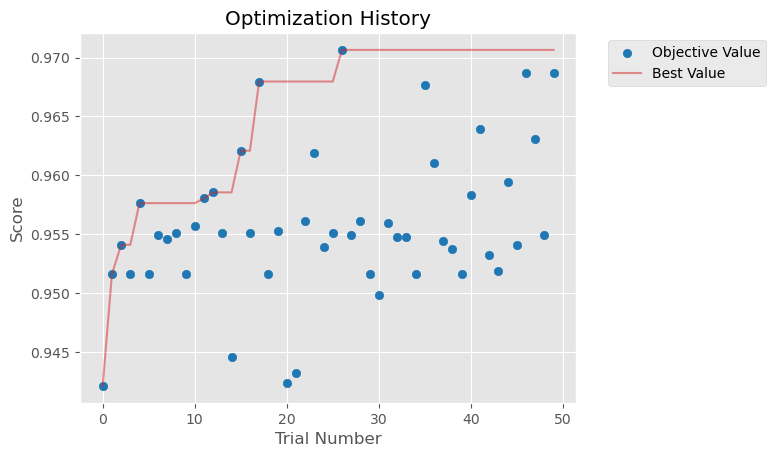

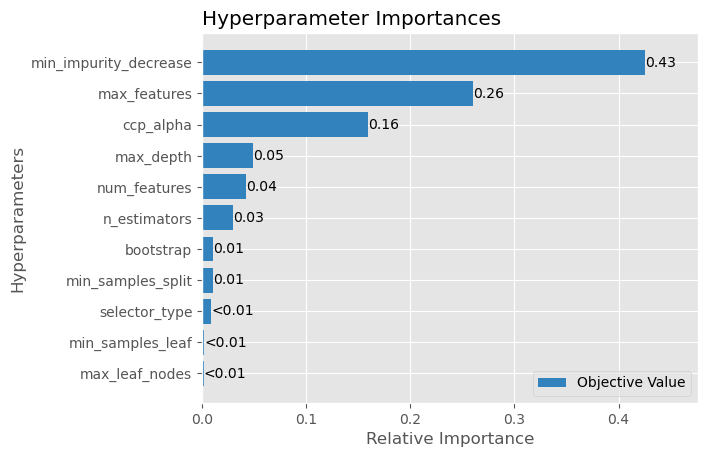

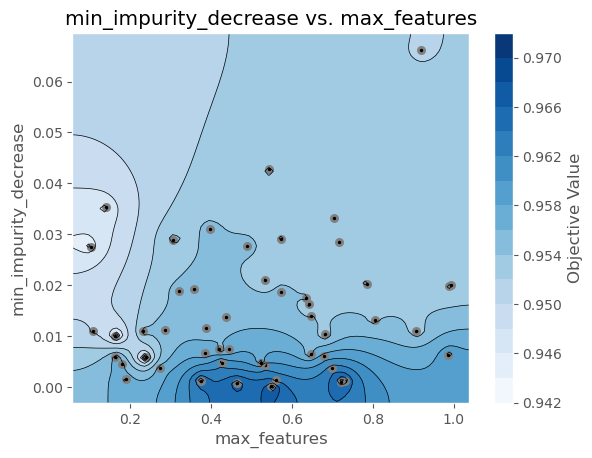

In [17]:
# a. Optuna results
from PyMLR import show_optuna
show_optuna(train_output_forest['optuna_study'])

Performing model agnostic analysis, please wait...
Permutation Importance...


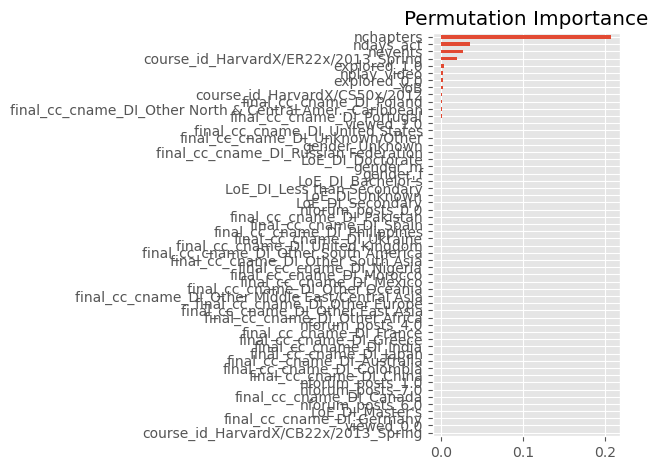

Interpretability plots saved to: model_agnostic
Done
Time elapsed: 61.28 sec



In [18]:
# b. Model agnostics
from PyMLR import model_agnostic
agnostic_output_forest = model_agnostic(train_model_forest, X_train, y_train, 
    preprocess_result= train_output_forest['preprocess_result'],
    selected_features= train_output_forest['selected_features'],
    output_dir= 'model_agnostic', show_perm=True)